In [1]:
import sys
sys.path.insert(0, '..')

import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
import matplotlib.pyplot as plt
import measure_metric.measureMetric as measureMetric

from stencilgen.stencil import *
from tsmgen.kernel import *
import stencilgen.bench as stencilbench
import tsmgen.benchmark as tsmbench
from predict import *

#% matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stencilgen.stencil
%aimport stencilgen.bench
%aimport predict

In [7]:
storeVolumes = []
loadVolumes = []
for r in range(1, 10):
    kernel = Kernel2DBoxStencil(stencil_range=r, l1only=False)
    
    measureMetric.measureBandwidthStart()
    block = (32, 8, 1)
    stencilbench.runKernel(kernel, kernel.getGrid(1, block, 15000, 15000), block)
    result = measureMetric.measureMetricStop()
    
    storeVolumes.append(result[1])
    loadVolumes.append(result[0])
    print("mem load: " + str(result[0] / 15000**2))
    print("mem store: " + str(result[1] / 15000**2))
    print("L2  load: " + str(result[2]*32 / 15000**2))
    print("L2  store: " + str(result[3]*32 / 15000**2))
    L2CLs, L1CLs = computeCacheVolumes(kernel, 32, block, (1,1,1))
    
    print("pred L1 CLs: " + str(len(L1CLs)))
    print("pred L2 volume: " + str(L2CLs * 32 / block[0] / block[1] / block[2]))
    print()

mem load: 8.005255822222223
mem store: 7.985171484444445
L2  load: 12.460571875555555
L2  store: 8.00319488


TypeError: 'Kernel2DBoxStencil' object is not iterable

In [ ]:
def compareSeries( xblocks, yblocks, ranges, **stencilArgs):
    best_values = []

    measuredValues = []
    predictedValues = []
   
    xtickCounter = 0
    xticks = []
    xtickLabels = []

    for r in ranges:
        kernel = Kernel2DBoxStencil(stencil_range=r, **stencilArgs)
    
        for xblock in xblocks:
            
            newXtick = xtickCounter
            for yblock in yblocks:
                if xblock*yblock > 1024 or xblock*yblock < 64:
                    continue

                block = (xblock, yblock, 1)

                print("r={}, block={}x{}".format(r, xblock, yblock))
                if newXtick == xtickCounter:
                    newLabel = "r={};{}x{}".format(r, xblock, yblock)
                measuredValues.append( stencilbench.benchKernel(kernel, 11, (xblock, yblock, 1))[2])
                predictedValues.append(predictPerformance(kernel, block, (1,1,1), 32) )
                print("Meas / Pred (GFlop/s): {:.0f} / {:.0f}".format( measuredValues[-1], predictedValues[-1]))
                print()
                xtickCounter += 1
                
            if newXtick != xtickCounter:
                xticks.append(newXtick)
                xtickLabels.append(newLabel)        

        print()
    return measuredValues, predictedValues, xticks, xtickLabels

def plotComparison(measuredValues, predictedValues, xticks, xtickLabels):
    fig, ax = plt.subplots()
    fig.set_figwidth(9)
    fig.set_figheight(4.5)
    fig.set_dpi(200)

    ax.plot(predictedValues, "-+", label="predicted",  color="#CCE699", linewidth=3, markersize=9, markeredgewidth=2, markeredgecolor="#B5CC88")
    ax.plot(measuredValues, "-x", label="measured", color="#99B3E6", linewidth=3, markersize=7, markeredgewidth=2, markeredgecolor="#889FCC")

    #ax.set_yscale("log")

    ax.set_xticks(xticks)
    ax.set_xticklabels( xtickLabels, rotation=60, rotation_mode="anchor", horizontalalignment="right")
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_xlim(-1, len(predictedValues))

    fig.tight_layout()
    ax.legend()
    ax.grid()
    plt.show()


In [5]:
l1data = compareSeries([ 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], [1, 2, 4, 8, 16, 32, 64, 128, 256, 512,1024], [4], l1only=True)

r=4, block=2x32
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120  1280   29952  1296        0       0  36352
       5120   160   54624   648        0       0  59904
Meas / Pred (GFlop/s): 278 / 306

r=4, block=2x64
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560  1280   14976  1296        0       0  18816
       2560   160   57184   648        0       0  59904
Meas / Pred (GFlop/s): 275 / 306

r=4, block=2x128
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280  1280    7488  1296        0       0  10048
       1280   160   58464   648        0       0  59904
Meas / Pred (GFlop/s): 275 / 306

r=4, block=2x256
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640  1280    3744  1296        0       0   5664
        640   160   59104   648        0       0  59904
Meas / Pred (GFlop/s): 276 / 306

r=4, block=2x512
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1280    1872  1296        0       0   34

Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1280     324  1296        0       0   2896
        320   160    9888   648        0       0  10368
Meas / Pred (GFlop/s): 1484 / 1766

r=4, block=1024x1
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1280     324  1296        0       0   2896
        320   160    9888   648        0       0  10368
Meas / Pred (GFlop/s): 1478 / 1766




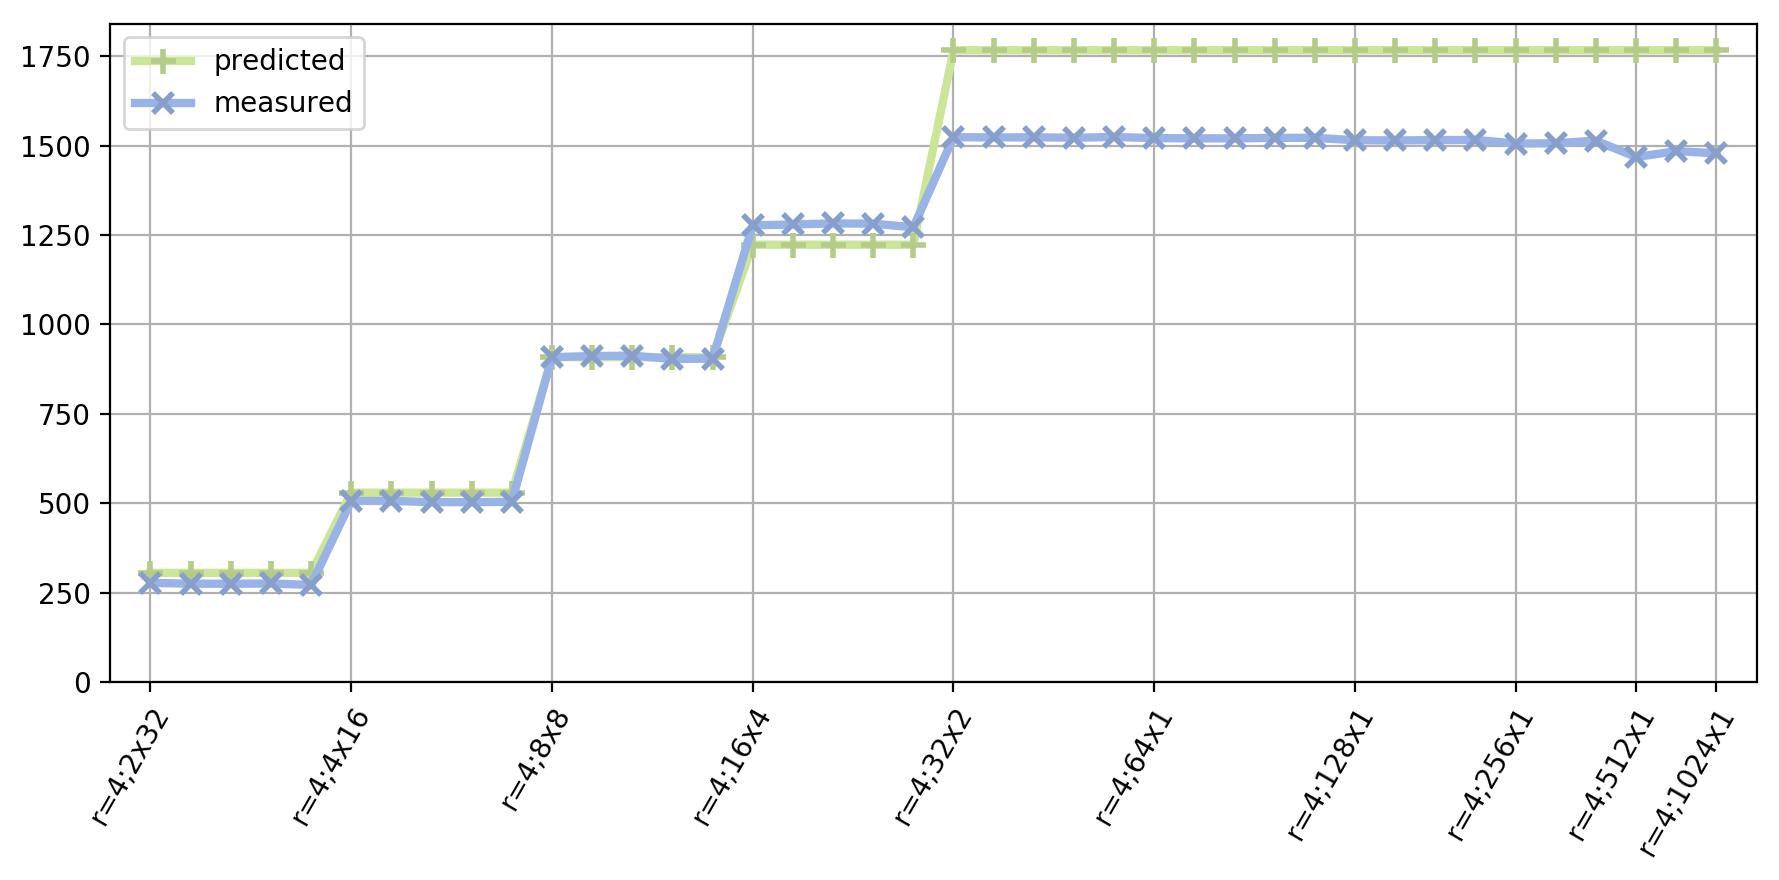

In [6]:
plotComparison(*l1data)

In [31]:
memdata = compareSeries([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], [1, 2, 4, 8, 16, 32, 64, 128, 256], [1, 2, 3])

r=1, block=1x64
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120  1280    6336   144     4654    7005  24395
       5120   160    7093    72      210     249  12832
Meas / Pred (GFlop/s): 101 / 159

r=1, block=1x128
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560  1280    3168   144     4654    6911  18573
       2560   160    9559    72      210     249  12738
Meas / Pred (GFlop/s): 97 / 160

r=1, block=1x256
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280  1280    1584   144     4654    6864  15662
       1280   160   10808    72      210     248  12706
Meas / Pred (GFlop/s): 87 / 160

r=1, block=2x32
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120  1280    3648   144     4654    3994  18696
       5120   160    1877    72      244     245   7646
Meas / Pred (GFlop/s): 187 / 266

r=1, block=2x64
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560  1280    1824   144     4654    3900  14218


        640   160      24    73     3525     242   4640
Meas / Pred (GFlop/s): 437 / 439

r=1, block=256x4
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1280      36   144     4654    1960   8358
        320   160      24    73     3855     237   4645
Meas / Pred (GFlop/s): 436 / 438

r=1, block=512x1
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640  1280      72   144     4654    3089   9807
        640   160      24    73     3492     274   4639
Meas / Pred (GFlop/s): 435 / 439

r=1, block=512x2
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1280      36   144     4654    2324   8722
        320   160      24    73     3851     241   4645
Meas / Pred (GFlop/s): 435 / 438

r=1, block=1024x1
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1280      36   144     4654    3071   9469
        320   160      24    73     3818     273   4644
Meas / Pred (GFlop/s): 429 / 438


r=2, block=1x64
Tblocksched  Tin

       1280   160     157   219     2680     282   4621
Meas / Pred (GFlop/s): 957 / 1223

r=2, block=128x4
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640  1280     200   400     4654    2395   9369
        640   160     156   219     3374     243   4637
Meas / Pred (GFlop/s): 980 / 1219

r=2, block=128x8
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1280     100   400     4654    1995   8649
        320   160     156   219     3706     237   4643
Meas / Pred (GFlop/s): 947 / 1218

r=2, block=256x1
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280  1280     400   400     4654    4676  12290
       1280   160     151   219      494    2559   4712
Meas / Pred (GFlop/s): 963 / 1200

r=2, block=256x2
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640  1280     200   400     4654    3124  10098
        640   160     156   219     3340     277   4636
Meas / Pred (GFlop/s): 962 / 1219

r=2, block=256x4
Tblocksched 

Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280  1280     784   784     4654    2912  10910
       1280   160    4358   479      281     237   6316
Meas / Pred (GFlop/s): 1213 / 1754

r=3, block=64x8
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640  1280     392   784     4654    2277   9635
        640   160    4979   480      282     237   6298
Meas / Pred (GFlop/s): 1274 / 1759

r=3, block=64x16
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1280     196   784     4654    1960   8998
        320   160    5291   480      282     237   6290
Meas / Pred (GFlop/s): 1204 / 1761

r=3, block=128x1
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560  1280    1568   784     4654    6393  16455
       2560   160    1855   473      273    1670   6518
Meas / Pred (GFlop/s): 1160 / 1700

r=3, block=128x2
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280  1280     784   784     4654    3994  11992
     

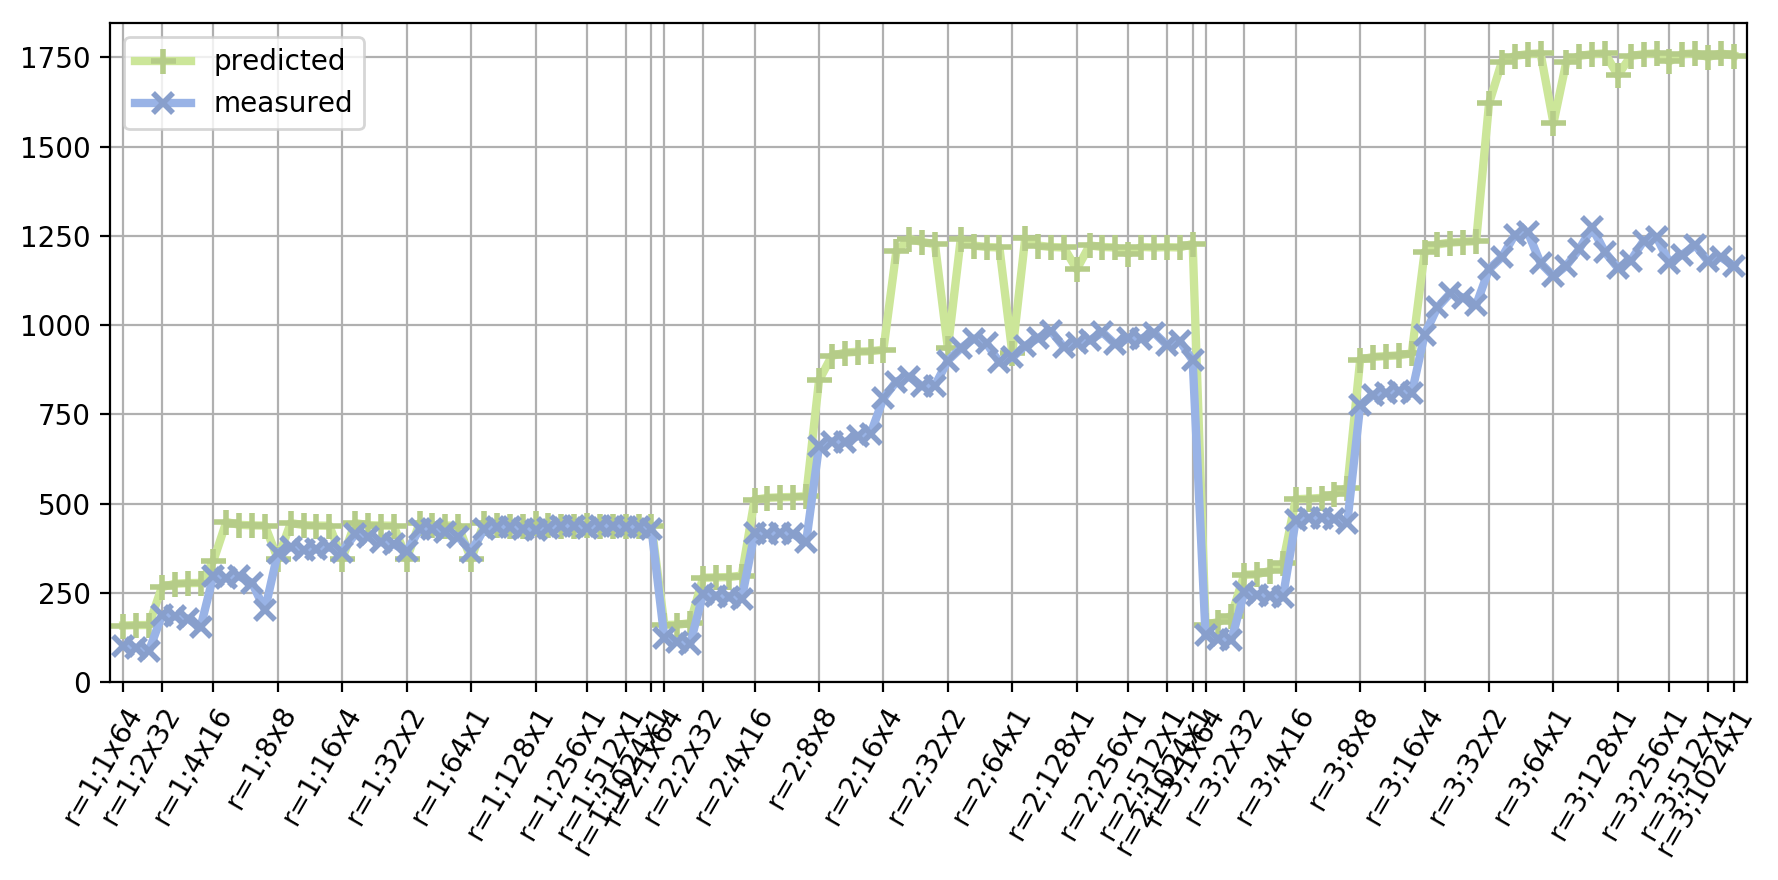

In [32]:
plotComparison(*memdata)

In [49]:
maxOverlap = compareSeries([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], [1, 2, 4, 8, 16, 32, 64, 128, 256], [7])

r=7, block=1x64
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120  1280  158400  3600     4654   15472 184926
       5120   160  311073  1800      210     237 316800
Meas / Pred (GFlop/s): 138 / 161

r=7, block=1x128
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560  1280   79200  3600     4654   14155 101849
       2560   160  313633  1800      210     237 316800
Meas / Pred (GFlop/s): 129 / 161

r=7, block=1x256
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280  1280   39600  3600     4654   13496  60310
       1280   160  314913  1800      210     237 316800
Meas / Pred (GFlop/s): 126 / 161

r=7, block=2x32
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120  1280   84000  3600     4654   11615 106669
       5120   160  162273  1800      210     237 168000
Meas / Pred (GFlop/s): 266 / 303

r=7, block=2x64
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560  1280   42000  3600     4654    9968  6046

Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1280     900  3600     4654    4394  14248
        320   160   27873  1800      210     237  28800
Meas / Pred (GFlop/s): 1479 / 1766

r=7, block=512x1
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640  1280    1800  3600     4654   12438  22612
        640   160   27553  1800      210     237  28800
Meas / Pred (GFlop/s): 1236 / 1766

r=7, block=512x2
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1280     900  3600     4654    7005  16859
        320   160   27873  1800      210     237  28800
Meas / Pred (GFlop/s): 1440 / 1766

r=7, block=1024x1
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1280     900  3600     4654   12261  22116
        320   160   27873  1800      210     237  28800
Meas / Pred (GFlop/s): 1356 / 1766




In [54]:
randomOverlap = compareSeries([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], [1, 2, 4, 8, 16, 32, 64, 128, 256], [7])

r=7, block=1x64
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120  1280  158400  3600     4654   15472 184926
       5120   160  311164  1803      210     237 316891
Meas / Pred (GFlop/s): 138 / 161

r=7, block=1x128
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560  1280   79200  3600     4654   14155 101849
       2560   160  313683  1803      210     237 316850
Meas / Pred (GFlop/s): 129 / 161

r=7, block=1x256
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       1280  1280   39600  3600     4654   13496  60310
       1280   160  314943  1803      210     237 316830
Meas / Pred (GFlop/s): 126 / 161

r=7, block=2x32
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       5120  1280   84000  3600     4654   11615 106669
       5120   160  162366  1810      210     237 168093
Meas / Pred (GFlop/s): 266 / 303

r=7, block=2x64
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
       2560  1280   42000  3600     4654    9968  6046

        640   160   27573  2206      210     237  28820
Meas / Pred (GFlop/s): 1269 / 1765

r=7, block=256x4
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1280     900  3600     4654    4394  14248
        320   160   27888  2206      210     237  28815
Meas / Pred (GFlop/s): 1479 / 1765

r=7, block=512x1
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        640  1280    1800  3600     4654   12438  22612
        640   160   27573  2206      210     237  28820
Meas / Pred (GFlop/s): 1236 / 1765

r=7, block=512x2
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1280     900  3600     4654    7005  16859
        320   160   27888  2206      210     237  28815
Meas / Pred (GFlop/s): 1440 / 1765

r=7, block=1024x1
Tblocksched  Tint TL1thru   TDP Tlat_mem Tlat_L2 Ttotal
        320  1280     900  3600     4654   12261  22116
        320   160   27888  2206      210     237  28815
Meas / Pred (GFlop/s): 1357 / 1765




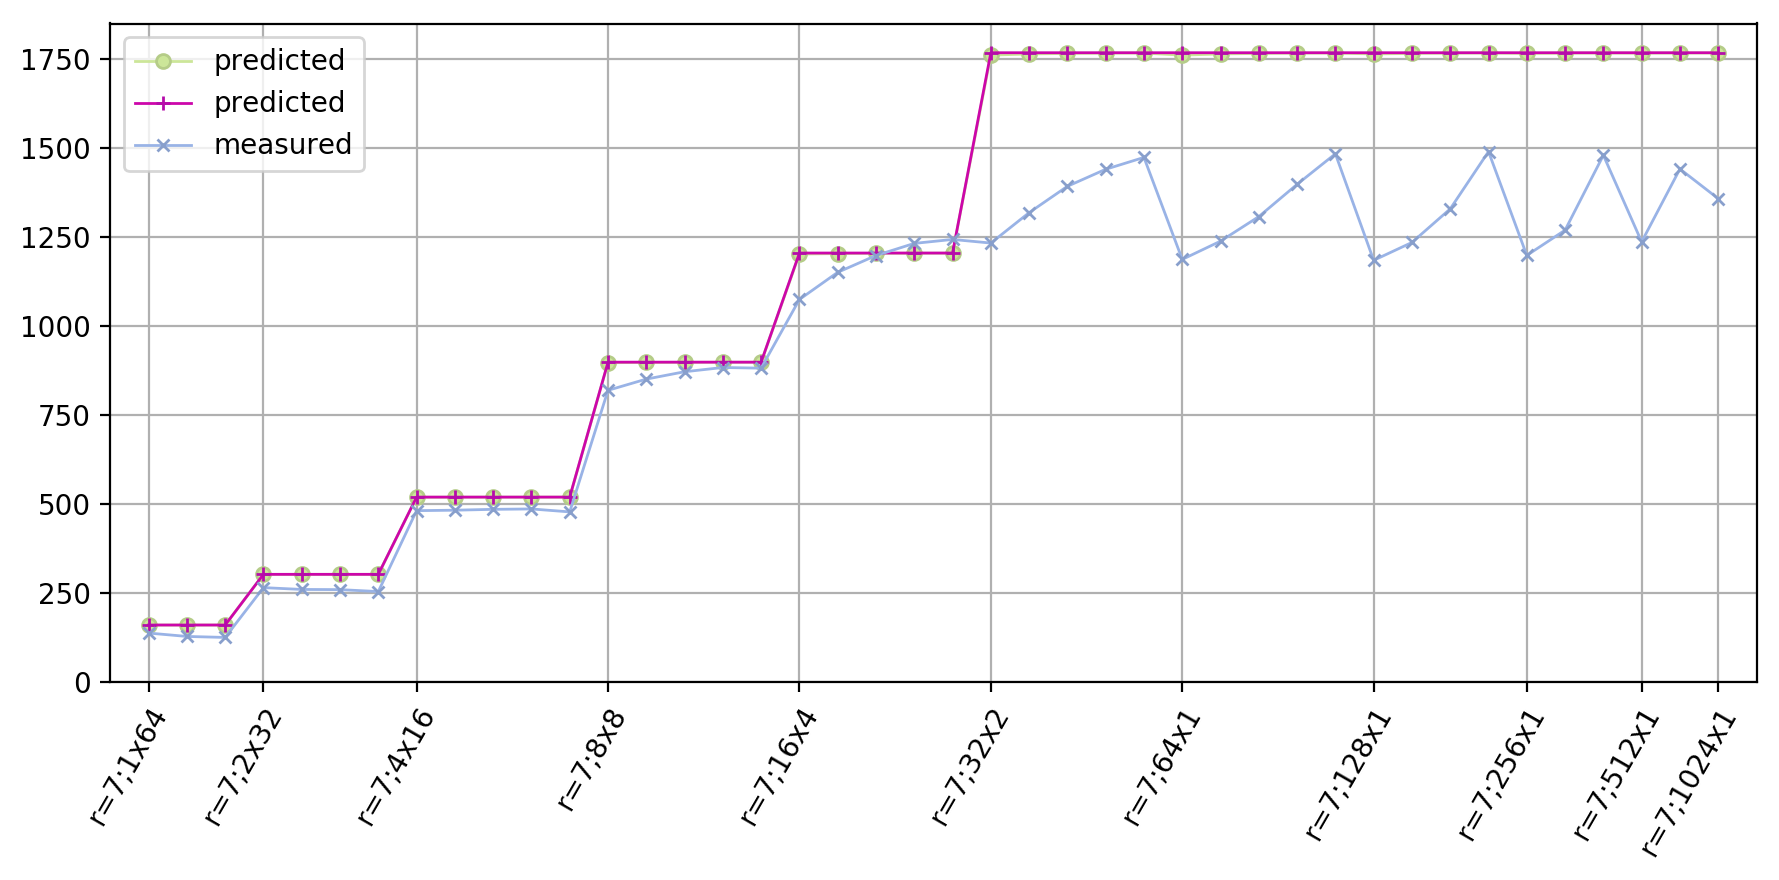

In [55]:
fig, ax = plt.subplots()
fig.set_figwidth(9)
fig.set_figheight(4.5)
fig.set_dpi(200)

ax.plot(randomOverlap[1], "-o", label="predicted",  color="#CCE699", linewidth=1, markersize=5, markeredgewidth=1, markeredgecolor="#B5CC88")
ax.plot(maxOverlap[1], "-+", label="predicted",  color="#CC06AA", linewidth=1, markersize=5, markeredgewidth=1, markeredgecolor="#B50CAA")
ax.plot(randomOverlap[0], "-x", label="measured", color="#99B3E6", linewidth=1, markersize=4, markeredgewidth=1, markeredgecolor="#889FCC")

#ax.set_yscale("log")

ax.set_xticks(randomOverlap[2])
ax.set_xticklabels( randomOverlap[3], rotation=60, rotation_mode="anchor", horizontalalignment="right")
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlim(-1, len(randomOverlap[0]))

fig.tight_layout()
ax.legend()
ax.grid()
plt.show()